### Notebook Description

**U-Net Image Segmentation**

This notebook is designed to implement and understand the U-Net architecture, a deep learning model widely used for image segmentation tasks. The notebook walks through the process of preparing the dataset, building the U-Net model, training it, and evaluating its performance.

**Objectives:**
1. Understand the fundamentals of image segmentation and why U-Net is a popular choice for this task.
2. Learn how to preprocess and split image datasets for training and testing.
3. Implement the U-Net architecture using PyTorch.
4. Train the model and visualize its predictions to evaluate its effectiveness.

**How to Use This Notebook:**
- The notebook is divided into sections such as data preparation, model definition, training, and evaluation.
- Each section contains code and comments explaining the purpose of the steps.
- Students are encouraged to complete the TODO sections, which guide them to implement missing parts of the code or analyze results.

**What You'll Learn:**
- Practical knowledge of handling image datasets.
- Building and customizing a U-Net model.
- Evaluating deep learning models for segmentation tasks.
- Gaining hands-on experience with PyTorch.

**Prerequisites:**
- Familiarity with Python and basic programming concepts.
- A basic understanding of deep learning and PyTorch.
- Knowledge of image processing concepts (optional but helpful).

**Tips for Success:**
- Follow the comments and instructions in the code.
- Refer to the provided links and resources to understand U-Net better.
- Experiment with the code to explore how changes affect the results.

---

This introduction can be added as a Markdown cell at the top of the notebook. Let me know if you'd like me to insert it into the notebook directly!

In [ ]:
# This cell imports the required libraries and sets up the environment for the U-Net project.
# TODO for Students: Review these imports and identify which libraries are unfamiliar to you. Research their purpose.

# General libraries for file handling and image processing
import os
import PIL
import time
import glob
import torch
import pickle

# Libraries for data manipulation and visualization
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Specific modules for image and path handling
from PIL import Image
from pathlib import Path
from sklearn.model_selection import train_test_split


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tarfile


file_path = '/content/drive/MyDrive/dataset.tar.gz'

with tarfile.open(file_path, 'r:gz') as tar:
    tar.extractall(path='/content/')


In [ ]:
# Specify the device to be used for computations.
# If a GPU is available, it will use GPU device 1 ("cuda:1"), otherwise it will fall back to the CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
data_folder = Path("dataset")
origins_folder = data_folder / "images"
masks_folder = data_folder / "masks"

In [ ]:
class LungDataset(torch.utils.data.Dataset):
    def __init__(self, origin_mask_list, origins_folder, masks_folder, transforms=None):
        self.origin_mask_list = origin_mask_list
        self.origins_folder = origins_folder
        self.masks_folder = masks_folder
        self.transforms = transforms

    def __getitem__(self, idx):
        img_name, mask_name = self.origin_mask_list[idx]
        origin = Image.open(os.path.join(self.origins_folder, f"{img_name}.png")).convert('RGB')
        mask = Image.open(os.path.join(self.masks_folder, f"{mask_name}.png")).convert('L')

        if self.transforms:
            transformed = self.transforms({"origin": origin, "mask": mask})
            origin, mask = transformed["origin"], transformed["mask"]

        return torchvision.transforms.functional.to_tensor(origin), torch.tensor(np.array(mask, dtype=np.uint8) / 255.0, dtype=torch.float32)

    def __len__(self):
        return len(self.origin_mask_list)

class Pad():
    def __init__(self, max_padding):
        self.max_padding = max_padding

    def __call__(self, sample):
        origin, mask = sample["origin"], sample["mask"]
        pad_left = np.random.randint(0, self.max_padding)
        pad_top = np.random.randint(0, self.max_padding)
        pad_right = np.random.randint(0, self.max_padding)
        pad_bottom = np.random.randint(0, self.max_padding)
        padding = (pad_left, pad_top, pad_right, pad_bottom)
        origin = torchvision.transforms.functional.pad(origin, padding)
        mask = torchvision.transforms.functional.pad(mask, padding, fill=0)
        return {"origin": origin, "mask": mask}

class Crop():
    def __init__(self, max_shift):
        self.max_shift = max_shift

    def __call__(self, sample):
        origin, mask = sample["origin"], sample["mask"]
        width, height = origin.size
        shift_x = np.random.randint(0, min(self.max_shift, width // 2))
        shift_y = np.random.randint(0, min(self.max_shift, height // 2))
        new_width, new_height = width - shift_x, height - shift_y
        origin = torchvision.transforms.functional.crop(origin, shift_y, shift_x, new_height, new_width)
        mask = torchvision.transforms.functional.crop(mask, shift_y, shift_x, new_height, new_width)
        return {"origin": origin, "mask": mask}

class Resize():
    def __init__(self, output_size):
        self.output_size = output_size

    def __call__(self, sample):
        origin, mask = sample["origin"], sample["mask"]
        origin = origin.resize(self.output_size, Image.BILINEAR)
        mask = mask.resize(self.output_size, Image.NEAREST)
        return {"origin": origin, "mask": mask}

def blend(origin, mask1=None, mask2=None):
    origin = torchvision.transforms.functional.to_pil_image(origin)
    masks = [mask1, mask2]

    for mask in masks:
        if mask is not None:
            mask = Image.fromarray((mask.numpy() * 255).astype(np.uint8))
            origin = Image.blend(origin, mask, alpha=0.5)

    return origin


In [ ]:
batch_size = 4
origins_list = [f.stem for f in origins_folder.glob("*.png")]
masks_list = [f.stem for f in masks_folder.glob("*.png")]
print(len(origins_list),len(masks_list))


800 704


In [ ]:

origin_mask_list = [(mask_name.replace("_mask", ""), mask_name) for mask_name in masks_list]


splits = {}
splits["train"], splits["test"] = train_test_split(origin_mask_list, test_size=0.2, random_state=42)
splits["train"], splits["val"] = train_test_split(splits["train"], test_size=0.1, random_state=42)

In [ ]:
val_test_transforms = lambda sample: Resize((256, 256))(sample)

def train_transform(sample):
    sample = Pad(20)(sample)
    sample = Crop(10)(sample)
    return Resize((256, 256))(sample)

datasets = {
    "train": LungDataset(splits["train"], origins_folder, masks_folder, transforms=train_transform),
    "val": LungDataset(splits["val"], origins_folder, masks_folder, transforms=val_test_transforms),
    "test": LungDataset(splits["test"], origins_folder, masks_folder, transforms=val_test_transforms),
}

dataloaders = {
    "train": torch.utils.data.DataLoader(datasets["train"], batch_size=16, shuffle=True, num_workers=os.cpu_count() // 2),
    "val": torch.utils.data.DataLoader(datasets["val"], batch_size=16, shuffle=False, num_workers=os.cpu_count() // 2),
    "test": torch.utils.data.DataLoader(datasets["test"], batch_size=16, shuffle=False, num_workers=os.cpu_count() // 2),
}


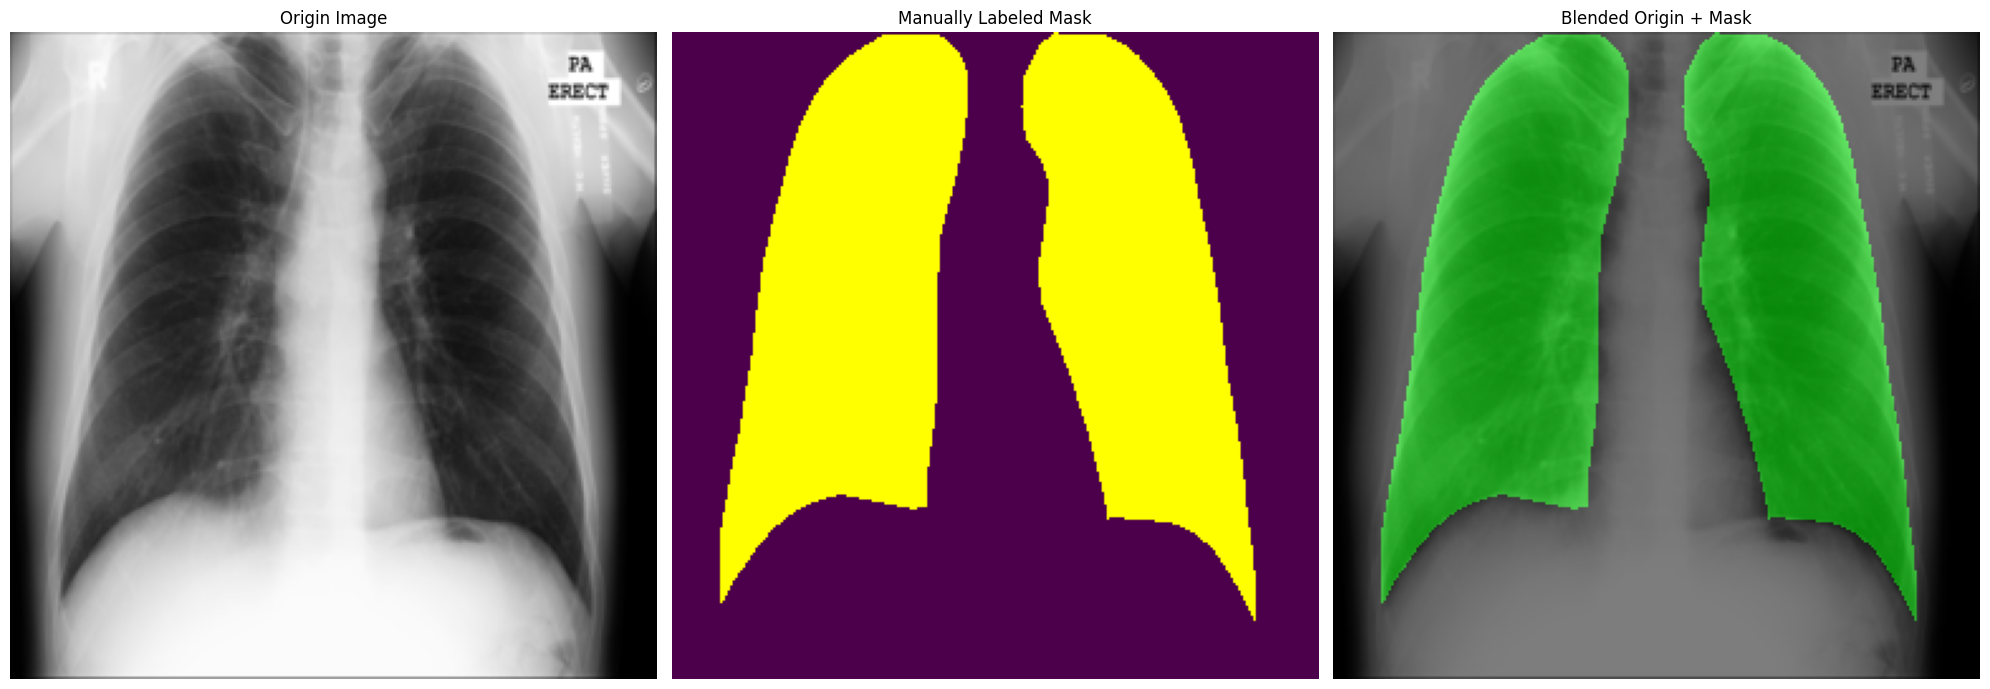

In [24]:
idx = 0
phase = "train"

plt.figure(figsize=(20, 10))
origin, mask = datasets[phase][idx]

# Create the mask_template with yellow foreground and dark purple background
mask_template = torch.stack([
    mask * 1.0 + (1 - mask) * 0.3,  # Red channel: yellow has red, purple has low red
    mask * 1.0 + (1 - mask) * 0.0,  # Green channel: yellow has green, purple does not
    mask * 0.0 + (1 - mask) * 0.3   # Blue channel: purple has low blue, yellow does not
], dim=-1)

pil_origin = torchvision.transforms.functional.to_pil_image(origin)
pil_mask_template = Image.fromarray((mask_template.numpy() * 255).astype(np.uint8))

# Display the original image
plt.subplot(1, 3, 1)
plt.imshow(pil_origin, cmap="gray")
plt.title("Origin Image")
plt.axis("off")

# Display the manually labeled mask
plt.subplot(1, 3, 2)
plt.imshow(pil_mask_template)
plt.title("Manually Labeled Mask")
plt.axis("off")

# Create a blended image with the mask overlaid in green
blended_image = blend(
    origin,
    torch.stack([torch.zeros_like(mask), mask, torch.zeros_like(mask)], dim=-1)
)
plt.subplot(1, 3, 3)
plt.imshow(blended_image)
plt.title("Blended Origin + Mask")
plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
class Block(torch.nn.Module):
    def __init__(self, in_channels, mid_channel, out_channels, batch_norm=False):
        super().__init__()
        # TODO: Define the first convolutional layer
        self.conv1 = torch.nn.Conv2d(in_channels, mid_channel, kernel_size=3, stride=1, padding=1)
        # TODO: Define the second convolutional layer
        self.conv2 = torch.nn.Conv2d(mid_channel, out_channels, kernel_size=3, stride=1, padding=1)

        self.batch_norm = batch_norm
        if batch_norm:
            # TODO: Define batch normalization layers
            self.bn1 = torch.nn.BatchNorm2d(mid_channel)
            self.bn2 = torch.nn.BatchNorm2d(out_channels)

    def forward(self, x):
        # TODO: Apply the first convolutional layer and batch normalization (if enabled)
        # Apply first convolution and batch normalization (if enabled)
        x = self.conv1(x)
        if self.batch_norm:
            x = self.bn1(x)
        x = torch.nn.functional.relu(x)

        # Apply second convolution and batch normalization (if enabled)
        x = self.conv2(x)
        if self.batch_norm:
            x = self.bn2(x)
        x = torch.nn.functional.relu(x)

        return x


class UNet(torch.nn.Module):
    def up(self, x, size):
        # TODO: Implement upsampling
        pass

    def down(self, x):
        # TODO: Implement max pooling for downsampling
        pass

    def __init__(self, in_channels, out_channels, batch_norm=False, upscale_mode="nearest"):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.batch_norm = batch_norm
        self.upscale_mode = upscale_mode

        # TODO: Define encoder blocks
        self.enc1 = None
        self.enc2 = None
        self.enc3 = None
        self.enc4 = None

        # TODO: Define center block
        self.center = None

        # TODO: Define decoder blocks
        self.dec4 = None
        self.dec3 = None
        self.dec2 = None
        self.dec1 = None

        # TODO: Define final output layer
        self.out = None

    def forward(self, x):
        # TODO: Implement forward pass for UNet
        pass


class PretrainedUNet(torch.nn.Module):
    def up(self, x, size):
        # TODO: Implement upsampling
        return torch.nn.functional.interpolate(x, size=size, mode=self.upscale_mode, align_corners=False)

    def down(self, x):
        # TODO: Implement max pooling for downsampling
        return torch.nn.functional.max_pool2d(x, kernel_size=2, stride=2)

    def __init__(self, in_channels, out_channels, batch_norm=False, upscale_mode="nearest"):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.batch_norm = batch_norm
        self.upscale_mode = upscale_mode

        # TODO: Define initial convolution layer to adjust input channels
        self.init_conv = torch.nn.Conv2d(in_channels, 3, kernel_size=1)

        # TODO: Extract pretrained VGG-11 encoder layers
        vgg = torchvision.models.vgg11_bn(pretrained=True).features
        self.conv1 = vgg[0]
        self.conv2 = vgg[4]
        self.conv3 = vgg[8]
        self.conv3s = vgg[11]
        self.conv4 = vgg[15]
        self.conv4s = vgg[18]
        self.conv5 = vgg[22]
        self.conv5s = vgg[25]

        # TODO: Define center and decoder blocks
        self.center = Block(512, 512, 256, batch_norm=batch_norm)
        self.dec5 = Block(768, 512, 256, batch_norm=batch_norm)
        self.dec4 = Block(768, 512, 128, batch_norm=batch_norm)
        self.dec3 = Block(384, 256, 64, batch_norm=batch_norm)
        self.dec2 = Block(192, 128, 32, batch_norm=batch_norm)
        self.dec1 = Block(96, 64, 32, batch_norm=batch_norm)

        # TODO: Define final output layer
        self.out = torch.nn.Conv2d(32, out_channels, kernel_size=1)

    def forward(self, x):
        # TODO: Implement forward pass for Pretrained UNet
        # Encoding path
        x = self.init_conv(x)
        enc1 = self.conv1(x)
        x = self.down(enc1)
        enc2 = self.conv2(x)
        x = self.down(enc2)
        enc3 = self.conv3(x)
        x = self.conv3s(enc3)
        x = self.down(x)
        enc4 = self.conv4(x)
        x = self.conv4s(enc4)
        x = self.down(x)
        enc5 = self.conv5(x)
        x = self.conv5s(enc5)
        x = self.down(x)

        # Center block
        x = self.center(x)

        # Decoding path
        x = self.up(x, enc5.size()[2:])
        x = torch.cat([x, enc5], dim=1)
        x = self.dec5(x)

        x = self.up(x, enc4.size()[2:])
        x = torch.cat([x, enc4], dim=1)
        x = self.dec4(x)

        x = self.up(x, enc3.size()[2:])
        x = torch.cat([x, enc3], dim=1)
        x = self.dec3(x)

        x = self.up(x, enc2.size()[2:])
        x = torch.cat([x, enc2], dim=1)
        x = self.dec2(x)

        x = self.up(x, enc1.size()[2:])
        x = torch.cat([x, enc1], dim=1)
        x = self.dec1(x)

        # Output layer
        x = self.out(x)
        return x


In [ ]:
def jaccard(y_true, y_pred):
    """Calculate Jaccard Index (IoU) for a batch of images."""
    num = y_true.size(0)  # Batch size
    eps = 1e-7  # Small constant to prevent division by zero

    # Flatten the tensors for pixel-wise comparison
    y_true_flat = y_true.view(num, -1)
    y_pred_flat = y_pred.view(num, -1)

    # Calculate intersection and union
    intersection = (y_true_flat * y_pred_flat).sum(1)
    union = ((y_true_flat + y_pred_flat) > 0.0).float().sum(1)

    # Compute Jaccard score
    score = intersection / (union + eps)
    return score.sum() / num  # Average score over batch


def dice(y_true, y_pred):
    """Calculate Dice coefficient (F1 score) for a batch of images."""
    num = y_true.size(0)  # Batch size
    eps = 1e-7  # Small constant to prevent division by zero

    # Flatten the tensors for pixel-wise comparison
    y_true_flat = y_true.view(num, -1)
    y_pred_flat = y_pred.view(num, -1)

    # Calculate intersection
    intersection = (y_true_flat * y_pred_flat).sum(1)

    # Compute Dice score
    score = (2 * intersection) / (y_true_flat.sum(1) + y_pred_flat.sum(1) + eps)
    return score.sum() / num  # Average score over batch


In [ ]:
# TODO: Initialize the PretrainedUNet model with appropriate parameters.
unet = PretrainedUNet(
    in_channels=3,  # TODO: Specify the number of input channels
    out_channels=2,  # TODO: Specify the number of output channels
    batch_norm=True,  # TODO: Enable or disable batch normalization
    upscale_mode="bilinear"  # TODO: Specify the upsampling mode
)

# TODO: Move the model to the appropriate device (CPU or GPU).
unet = unet.to(device)

# TODO: Print the model to verify its structure.
unet


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth
100%|██████████| 507M/507M [00:03<00:00, 147MB/s]


PretrainedUNet(
  (init_conv): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3s): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4s): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5s): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (center): Block(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchN

In [ ]:
# TODO: Set training configurations such as log file, epochs, and optimizer.
train_log_filename = "training_log.txt"  # TODO: Specify log file name
epochs = 8  # TODO: Define the number of epochs
best_val_loss = np.inf
model_name = "best_model.pth"  # TODO: Specify model checkpoint name
optimizer = torch.optim.Adam(unet.parameters(), lr=1e-4)  # TODO: Initialize optimizer (e.g., Adam)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
# TODO: Insitialize history list to store training and validation metrics.
hist = []

# Training loop
for e in range(epochs):
    start_t = time.time()  # Track the start time of the epoch.

    # Training phase
    print("train phase")
    unet.train()
    train_loss = 0.0
    for origins, masks in dataloaders["train"]:
        num = origins.size(0)  # Batch size

        # TODO: Move input data and targets to the device (CPU or GPU).
        origins = origins.to(device)  # TODO: Move origins to device
        masks = masks.to(device)  # TODO: Move masks to device

        # TODO: Reset gradients and perform forward and backward passes.
        optimizer.zero_grad()
        # Forward pass
        outs = unet(origins)

        # Compute loss
        loss = torch.nn.functional.cross_entropy(outs, masks.long())  # Using CrossEntropyLoss
        loss.backward()  # Backward pass

        # Update weights
        optimizer.step()

        # TODO: Accumulate training loss for reporting.
        train_loss += loss.item() * num
        print(".", end="")  # Print progress
    scheduler.step()
    train_loss = train_loss / len(datasets['train'])  # Normalize training loss
    print()

    # Validation phase
    print("validation phase")
    unet.eval()
    val_loss = 0.0
    val_jaccard = 0.0
    val_dice = 0.0

    for origins, masks in dataloaders["val"]:
        num = origins.size(0)  # Batch size

        # TODO: Move validation data and targets to the device.
        origins = origins.to(device)
        masks = masks.to(device)

        with torch.no_grad():  # Disable gradient computation for validation.
            outs = unet(origins)  # TODO: Perform forward pass
            softmax = torch.nn.functional.softmax(outs, dim=1)  # TODO: Apply log-softmax
            val_loss += torch.nn.functional.cross_entropy(outs, masks.long()).item() * num  # TODO: Compute validation loss
            preds = (softmax[:, 1, :, :] > 0.5).float()
            # TODO: Compute Jaccard and Dice metrics for evaluation.
            val_jaccard += jaccard(masks, preds).item() * num
            val_dice += dice(masks, preds).item() * num
        print(".", end="")  # Print progress
    val_loss = val_loss / len(datasets["val"])  # TODO: Normalize validation loss
    val_jaccard = val_jaccard / len(datasets["val"])  # TODO: Normalize Jaccard score
    val_dice = val_dice / len(datasets["val"])  # TODO: Normalize Dice score
    print()

    end_t = time.time()  # Track the end time of the epoch.
    spended_t = end_t - start_t

    # TODO: Log training and validation metrics.
    with open(train_log_filename, "a") as train_log_file:
        report = (f"Epoch: {e+1}/{epochs}, Time: {spended_t:.2f}s, "
                  f"Train Loss: {train_loss:.4f}, "
                  f"Val Loss: {val_loss:.4f}, "
                  f"Val Jaccard: {val_jaccard:.4f}, "
                  f"Val Dice: {val_dice:.4f}")  # TODO: Format report string

        # TODO: Append metrics to the history list for future analysis.
        hist.append({
            "time": spended_t,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "val_jaccard": val_jaccard,
            "val_dice": val_dice,
        })

        print(report)  # TODO: Print the metrics
        train_log_file.write(report + "\n")  # TODO: Write metrics to the log file
        print()

    # I save best model parameters
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(unet.state_dict(), model_name)
        print(f"Model saved as {model_name}")


train phase
................................
validation phase
....
Epoch: 1/8, Time: 168.54s, Train Loss: 0.3522, Val Loss: 0.4182, Val Jaccard: 0.7493, Val Dice: 0.8519

Model saved as best_model.pth
train phase
................................
validation phase
....
Epoch: 2/8, Time: 179.34s, Train Loss: 0.2458, Val Loss: 0.2763, Val Jaccard: 0.8434, Val Dice: 0.9138

Model saved as best_model.pth
train phase
................................
validation phase
....
Epoch: 3/8, Time: 179.86s, Train Loss: 0.2254, Val Loss: 0.2255, Val Jaccard: 0.8878, Val Dice: 0.9377

Model saved as best_model.pth
train phase
................................
validation phase
....
Epoch: 4/8, Time: 201.31s, Train Loss: 0.2127, Val Loss: 0.2147, Val Jaccard: 0.8547, Val Dice: 0.9159

Model saved as best_model.pth
train phase
................................
validation phase
....
Epoch: 5/8, Time: 178.20s, Train Loss: 0.2018, Val Loss: 0.1999, Val Jaccard: 0.8967, Val Dice: 0.9434

Model saved as best_model

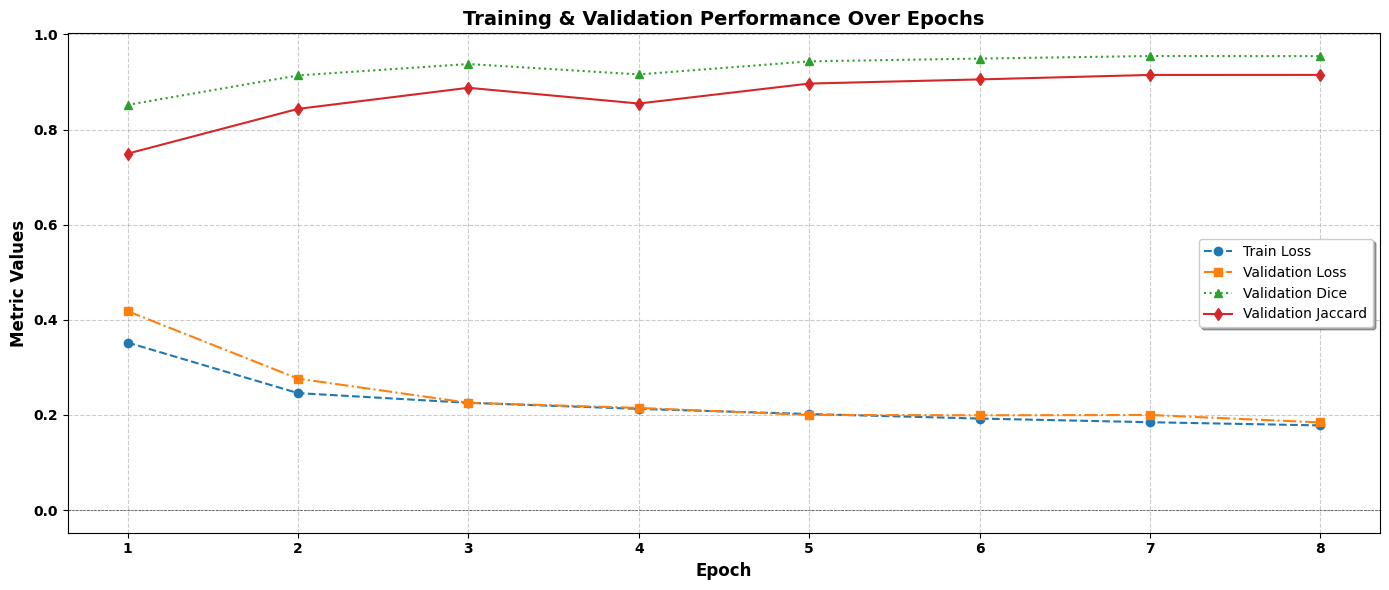

📌 Total Training Time: 24.06 minutes
📌 Average Time per Epoch: 180.45 seconds


In [25]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(14, 6))

epochs = np.arange(1, 9)
train_loss = [entry["train_loss"] for entry in hist]
val_loss = [entry["val_loss"] for entry in hist]
val_dice = [entry["val_dice"] for entry in hist]
val_jaccard = [entry["val_jaccard"] for entry in hist]

plt.plot(epochs, train_loss, linestyle="--", marker="o", color="#1f77b4", label="Train Loss")  # Blue
plt.plot(epochs, val_loss, linestyle="-.", marker="s", color="#ff7f0e", label="Validation Loss")  # Orange
plt.plot(epochs, val_dice, linestyle=":", marker="^", color="#2ca02c", label="Validation Dice")  # Green
plt.plot(epochs, val_jaccard, linestyle="-", marker="d", color="#d62728", label="Validation Jaccard")  # Red

plt.grid(True, which="both", linestyle="--", alpha=0.4, color="gray")  # Gradient-like subtle grid
plt.axhline(y=0, color="black", linewidth=0.5, linestyle="--", alpha=0.7)  # Horizontal baseline
plt.legend(loc="best", fontsize=10, frameon=True, shadow=True, fancybox=True)
plt.xlabel("Epoch", fontsize=12, fontweight="bold")
plt.ylabel("Metric Values", fontsize=12, fontweight="bold")
plt.title("Training & Validation Performance Over Epochs", fontsize=14, fontweight="bold")

plt.xticks(fontsize=10, fontweight="bold")
plt.yticks(fontsize=10, fontweight="bold")

plt.tight_layout()
plt.show()

times = np.array([entry["time"] for entry in hist])
total_time = np.sum(times) / 60
avg_time_per_epoch = np.mean(times)

print("=" * 50)
print(f"📌 Total Training Time: {total_time:.2f} minutes")
print(f"📌 Average Time per Epoch: {avg_time_per_epoch:.2f} seconds")
print("=" * 50)


In [19]:
import torch
import torch.nn.functional as F
from sklearn.metrics import jaccard_score, f1_score

# Set the model to evaluation mode
unet.eval()
test_loss = 0.0
test_jaccard = 0.0
test_dice = 0.0

# Iterate through the test dataloader
for origins, masks in dataloaders["test"]:
    num = origins.size(0)

    # Move data to the device (GPU or CPU)
    origins = origins.to(device)
    masks = masks.to(device)

    with torch.no_grad():  # Disable gradient calculation for evaluation
        # Perform forward pass
        outs = unet(origins)

        # Apply softmax to get probabilities (if it's a multi-class problem)
        softmax = F.softmax(outs, dim=1)

        # Compute test loss using a suitable loss function (e.g., CrossEntropyLoss or Dice Loss)
        criterion = torch.nn.CrossEntropyLoss()  # Assuming multi-class segmentation
        masks = masks.long()  # Convert masks to Long type
        test_loss += criterion(outs, masks).item()

        # Get class predictions (the index of the maximum value along the channel dimension)
        _, predicted = torch.max(softmax, 1)

        # Convert masks to float for metric calculations
        masks = masks.float()

        # Flatten the tensors for calculating metrics
        predicted_flat = predicted.view(-1).cpu().numpy()
        masks_flat = masks.view(-1).cpu().numpy()

        # Compute Jaccard index and Dice score
        test_jaccard += jaccard_score(masks_flat, predicted_flat, average='micro')
        test_dice += f1_score(masks_flat, predicted_flat, average='micro')

    print(".", end="")  # Print progress

# Compute average metrics
test_loss /= len(dataloaders["test"])
test_jaccard /= len(dataloaders["test"])
test_dice /= len(dataloaders["test"])

# Print the results
print()
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Jaccard Index: {test_jaccard:.4f}")
print(f"Test Dice Score: {test_dice:.4f}")


.........
Test Loss: 0.1829
Test Jaccard Index: 0.9574
Test Dice Score: 0.9782


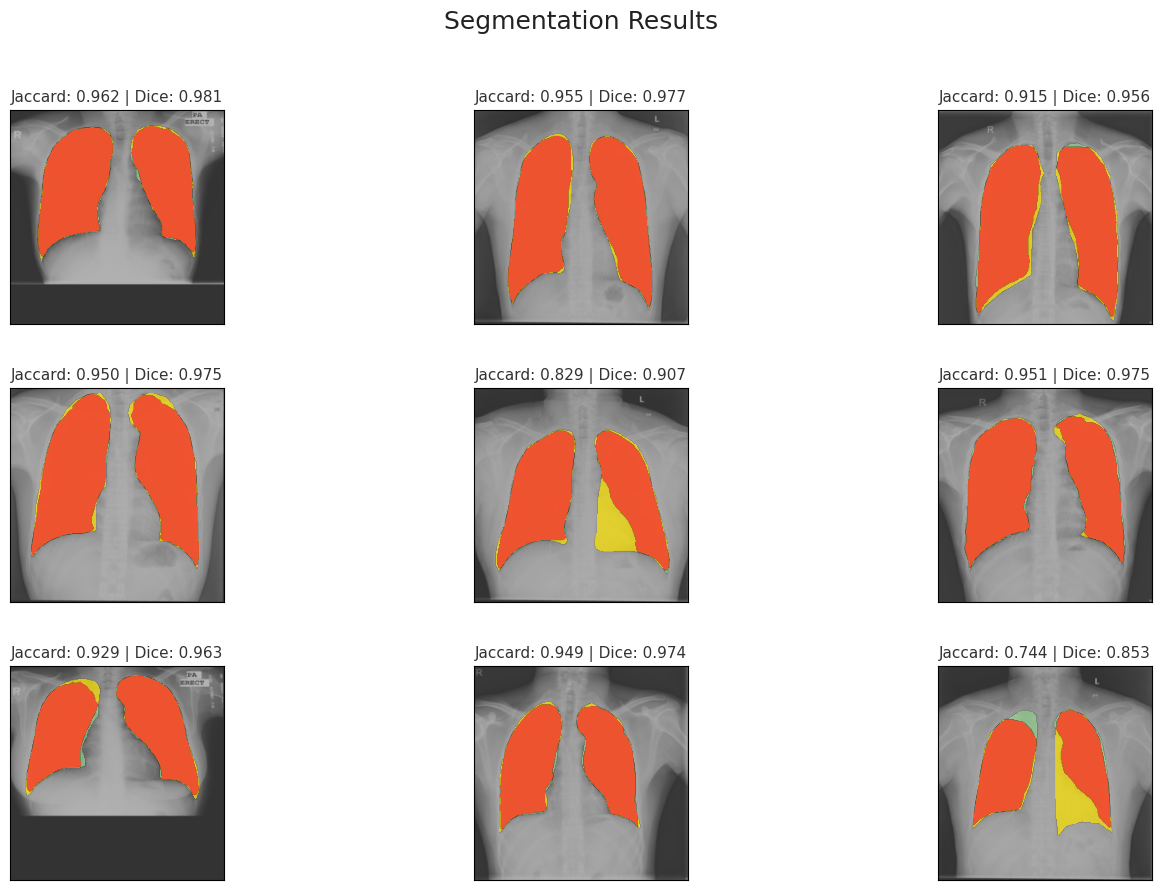


🟢 Green: Prediction | 🟡 Yellow: Ground Truth | 🔴 Red: Intersection


In [27]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, Subset
from matplotlib.colors import LinearSegmentedColormap

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_samples = 9
phase = 'test'

indices = torch.randint(0, len(datasets[phase]), (num_samples,)).tolist()
subset = Subset(datasets[phase], indices)
sample_loader = DataLoader(subset, batch_size=1)

cmap_green = LinearSegmentedColormap.from_list("green_map", plt.cm.Greens(np.linspace(0.4, 1, 256)))
cmap_yellow = LinearSegmentedColormap.from_list("yellow_map", [(1, 0.9, 0), (1, 0.8, 0.4)])
cmap_red = LinearSegmentedColormap.from_list("red_map", plt.cm.Reds(np.linspace(0.6, 1, 256)))

fig, axes = plt.subplots(3, 3, figsize=(15, 10), facecolor="white")
fig.suptitle("Segmentation Results", fontsize=18, color="#222")

for idx, (input_img, gt_mask) in enumerate(sample_loader):
    row, col = divmod(idx, 3)
    ax = axes[row, col]

    input_img = input_img.to(device)
    gt_mask = gt_mask.to(device).float()

    with torch.no_grad():
        output = unet(input_img)
        probs = torch.softmax(output, dim=1)
        pred_mask = torch.argmax(probs, dim=1).float()

    input_img = input_img.squeeze().cpu().numpy().transpose(1, 2, 0)
    gt_mask = gt_mask.squeeze().cpu().numpy()
    pred_mask = pred_mask.squeeze().cpu().numpy()

    intersection = np.logical_and(pred_mask, gt_mask)
    union = np.logical_or(pred_mask, gt_mask)
    iou = np.sum(intersection) / np.sum(union) if np.sum(union) > 0 else 0
    dice = (2 * np.sum(intersection)) / (np.sum(pred_mask) + np.sum(gt_mask)) if np.sum(pred_mask) + np.sum(gt_mask) > 0 else 0

    ax.imshow(input_img * 0.5 + 0.2)
    ax.imshow(np.ma.masked_where(pred_mask == 0, pred_mask), cmap=cmap_green, alpha=0.7)
    ax.imshow(np.ma.masked_where(gt_mask == 0, gt_mask), cmap=cmap_yellow, alpha=0.7)
    ax.imshow(np.ma.masked_where(intersection == 0, intersection), cmap=cmap_red, alpha=0.9)

    ax.set_xticks([]), ax.set_yticks([])
    ax.set_title(f"Jaccard: {iou:.3f} | Dice: {dice:.3f}", fontsize=11, color="#333")

plt.subplots_adjust(wspace=0.1, hspace=0.3, left=0.05, right=0.95, top=0.88)
plt.show()

print("\n🟢 Green: Prediction | 🟡 Yellow: Ground Truth | 🔴 Red: Intersection")
